# QAOA with QCut

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from iqm.qiskit_iqm import IQMFakeAdonis
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.primitives import BackendEstimator
from qiskit.quantum_info import PauliList, SparsePauliOp
from qiskit_aer import AerSimulator
from scipy.optimize import minimize

import QCut as ck
from QCut import cut


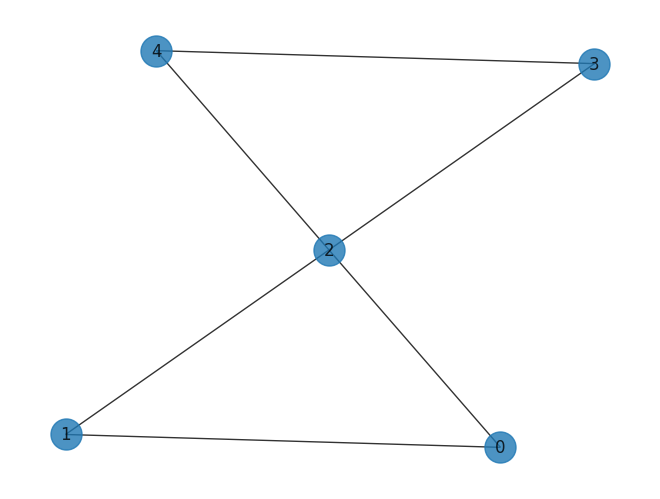

In [3]:
edges = [(0,1), (1,2), (2,0), (2,3), (2,4), (3,4)]
G = nx.Graph(edges)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [4]:
reformattedHamiltonian = {'paulis': PauliList(['IIIZZ', 'IIZIZ', 'IIZZI', 'IZZII', 'ZIZII', 'ZZIII']),
 'coefs': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'const': 0.0}

nqubits = 5

In [5]:
observables = SparsePauliOp(reformattedHamiltonian["paulis"], reformattedHamiltonian["coefs"])

In [6]:
def create_cut_qaoa_circ(n_layers):
    beta = [Parameter(f'beta_{i}') for i in range(n_layers)]
    gamma = [Parameter(f'gamma_{i}') for i in range(n_layers)]
    
    #create actual circuit object
    qc = QuantumCircuit(nqubits)
    #entagling layer
    for i in range(nqubits):
        qc.h(i)
    for layer_index in range(n_layers):
        #cost layer
        count = 0
        for i,j in G.edges():
            qc.rzz(2*gamma[layer_index], i, j)
            if count == 2:
                qc.append(cut, [max(i,j)])
            count += 1
        #mixing layer
        for i in range(nqubits):
            qc.rx(2*beta[layer_index], i)
    return qc

def create_qaoa_circ(n_layers):

    beta = [Parameter(f'beta_{i}') for i in range(n_layers)]
    gamma = [Parameter(f'gamma_{i}') for i in range(n_layers)]

    #create actual circuit object
    qc = QuantumCircuit(nqubits)
    #entagling layer
    for i in range(nqubits):
        qc.h(i)
    for layer_index in range(n_layers):
        #cost layer
        for i,j in G.edges():
            qc.rzz(2*gamma[layer_index], i, j)
        #mixing layer
        for i in range(nqubits):
            qc.rx(2*beta[layer_index], i)
    return qc

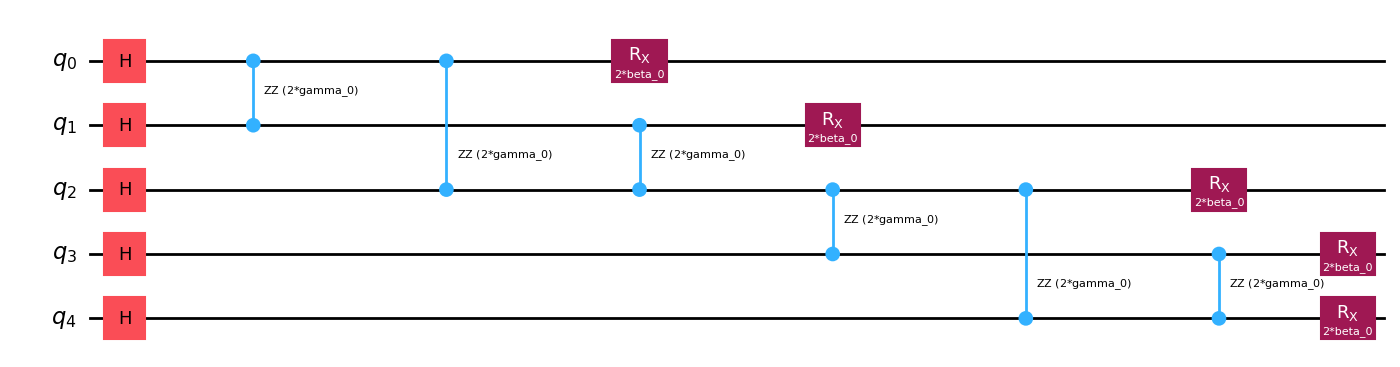

In [7]:
qc = create_qaoa_circ(1)

qc.draw("mpl")

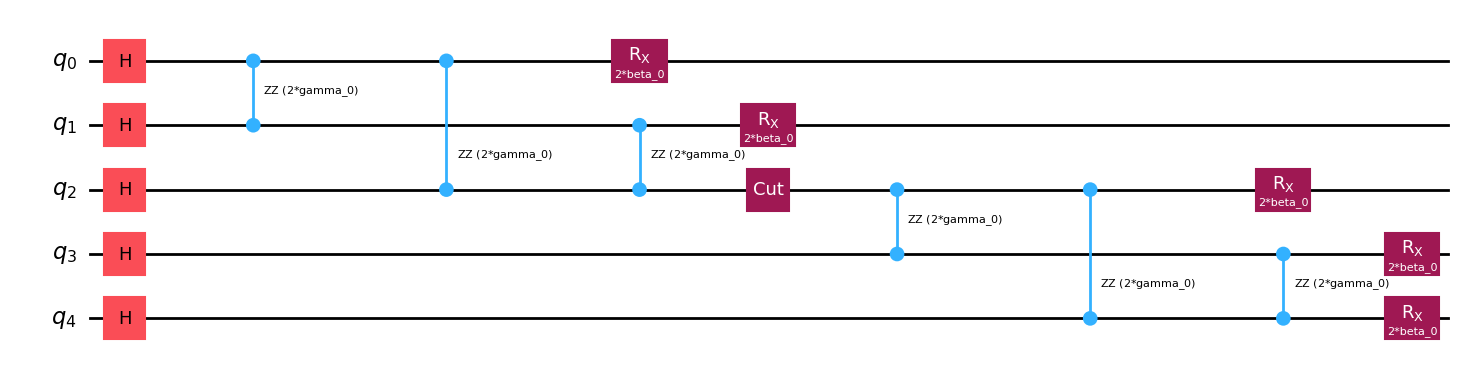

In [8]:
qca = create_cut_qaoa_circ(1)

qca.draw("mpl")

In [9]:
backend = IQMFakeAdonis()
sim = AerSimulator()

cut_circuit = ck.get_locations_and_subcircuits(qca)

transpiled = ck.transpile_subcircuits(cut_circuit, backend, optimization_level=3)

cut_experiment = ck.get_experiment_circuits(transpiled, observables)


tr_qc = transpile(qc, backend, optimization_level=3)
tr_obs = observables.apply_layout(tr_qc.layout)

In [14]:
def get_expectation_backend(circuit, hamiltonian, observables, backend):
    exps_uncut = np.empty(0)
    def execute_circ(theta):
        
        params = {}
        n_layers = len(theta)//2 # number of alternating unitaries
        for i in range(n_layers):
            params[f'beta_{i}'] = theta[i]
            params[f'gamma_{i}'] = theta[i + n_layers]

        p_circuit = circuit.assign_parameters(params, inplace=False)

        fake_estimator = BackendEstimator(backend)
        
        exps = (
            fake_estimator.run([p_circuit] * len([observables]), 
                               [observables]).result().values
        )

        f = hamiltonian["const"] + exps

        global exps_uncut
        exps_uncut = np.append(exps_uncut, f)

        return f
    
    return execute_circ, exps_uncut



def get_expectation_cut(cut_experiment, hamiltonian, observables, backend):
    exps_cut = np.empty(0) #store expectation value from each optimization step
    #execute circuit and calculate expectation value
    def execute_circ(theta):

        params = {}
        n_layers = len(theta)//2 # number of alternating unitaries
        for i in range(n_layers):
            params[f'beta_{i}'] = theta[i]
            params[f'gamma_{i}'] = theta[i + n_layers]

        p_cut_experiment = cut_experiment.assign_parameters(params, inplace=False)
        
        #run the experiments, apply the {0,1} -> [-1,1] post-processing function
        results = ck.run_experiments(p_cut_experiment, shots=2**12, backend=backend)

        reconstructed_expvals = ck.estimate_expectation_values(results, p_cut_experiment.expv_data())

        #Calculate the hamiltonian expectation value
        f = hamiltonian["const"]
        for i, j in zip(reconstructed_expvals, hamiltonian["coefs"]):
            f += i*j
        global exps_cut
        exps_cut =np.append(exps_cut, f)
        return f
    return execute_circ, exps_cut

In [ ]:
initial_params = [-np.pi, -np.pi]

expectation, exps_uncut = get_expectation_backend(tr_qc, reformattedHamiltonian, tr_obs, sim)
#minimize uncut qaoa cost using COBYLA
res_uncut = minimize(expectation,
                initial_params,
                method='COBYLA',
                options={'maxiter': 100}
                )
res_uncut

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -1.890625
       x: [-1.878e+00 -2.853e+00]
    nfev: 33
   maxcv: 0.0

In [16]:
expectation_cut, exps_cut = get_expectation_cut(cut_experiment, reformattedHamiltonian, observables, sim)
#minimize uncut qaoa cost using COBYLA
res_cut = minimize(expectation_cut,
                initial_params,
                method='COBYLA',
                options={'maxiter': 100}
                )
res_cut

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -1.9163243770599214
       x: [-2.824e+00 -3.437e+00]
    nfev: 33
   maxcv: 0.0

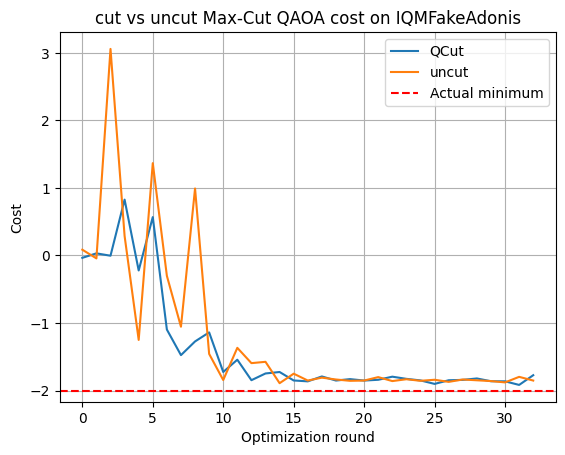

In [17]:
x = range(len(exps_cut))
x1 = range(len(exps_uncut))
plt.plot(x, exps_cut, label='QCut')
plt.plot(x1, exps_uncut, label='uncut')
plt.axhline(y=-2, color='r', linestyle='--', label = 'Actual minimum')
plt.xlabel('Optimization round')
plt.ylabel('Cost')
plt.title('cut vs uncut Max-Cut QAOA cost on IQMFakeAdonis')
plt.legend()
plt.grid(True)